In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [23]:
# data paths
path_train = '/home/paul/workspace/postdoc-year1/projects/calprotectin/data/cleaned_train_val_test/train_set.csv'
path_val = '/home/paul/workspace/postdoc-year1/projects/calprotectin/data/cleaned_train_val_test/validation_set.csv'
path_test = '/home/paul/workspace/postdoc-year1/projects/calprotectin/data/cleaned_train_val_test/test_set.csv'


# loading 
train_df = pd.read_csv(path_train)
val_df = pd.read_csv(path_val)
test_df = pd.read_csv(path_test)

In [24]:
total_y = len(train_df) + len(val_df) + len(test_df)
positives = train_df['diagnosis_infection'].sum() + val_df['diagnosis_infection'].sum() + test_df['diagnosis_infection'].sum()
print(positives/total_y)
print(positives)

0.2967032967032967
81.0


In [25]:
# all features
# FEATURES = ['birth_weight', 'total_gest_days',
#        'age_mother', 'gravidity', 'parity', 'umbilical_cord_ph',
#        'o2_demand', 'breath_aid', 'heart_rate',
#        'respiration_rate', 'rr_systolic', 'rr_diastolic', 'base_excess', 'gestation_diabetes',
#        'diabetes_type_1_2', 'adiposity', 'early_membrane_rupture',
#        'membrane_rupture_hours', 'early_labor_pain', 'green_amniotic_liquor',
#        'b_streptococcus', 'fever_sub_partu', 'antibiotics_prepartal', 'SCP1', 'CRP1', 'IL61', 'WBC1']

# only clinical features
# FEATURES = ['birth_weight', 'total_gest_days',
#        'age_mother', 'gravidity', 'parity', 'umbilical_cord_ph',
#        'o2_demand', 'breath_aid', 'heart_rate',
#        'respiration_rate', 'rr_systolic', 'rr_diastolic', 'base_excess', 'gestation_diabetes',
#        'diabetes_type_1_2', 'adiposity', 'early_membrane_rupture',
#        'membrane_rupture_hours', 'early_labor_pain', 'green_amniotic_liquor',
#        'b_streptococcus', 'fever_sub_partu', 'antibiotics_prepartal']

# only biomarkers
# FEATURES = ['SCP1', 'CRP1', 'IL61', 'WBC1']

# clinical and calprotectin 
FEATURES = ['birth_weight', 'total_gest_days',
       'age_mother', 'gravidity', 'parity', 'umbilical_cord_ph',
       'o2_demand', 'breath_aid', 'heart_rate',
       'respiration_rate', 'rr_systolic', 'rr_diastolic', 'base_excess', 'gestation_diabetes',
       'diabetes_type_1_2', 'adiposity', 'early_membrane_rupture',
       'membrane_rupture_hours', 'early_labor_pain', 'green_amniotic_liquor',
       'b_streptococcus', 'fever_sub_partu', 'antibiotics_prepartal', 'SCP1']


TARGET = 'diagnosis_infection'

In [26]:
X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_val = val_df[FEATURES]
y_val = val_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

In [27]:
# first evaluate only Logistic Regression
preprocessor = StandardScaler()
model_pipeline_LR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

In [28]:
model_pipeline_LR.fit(X_train, y_train)

# Evaluate on the unseen TEST set
y_pred_test_LR = model_pipeline_LR.predict(X_test)
y_pred_proba_test_LR = model_pipeline_LR.predict_proba(X_test)[:, 1]

print("\nPerformance on the Test Set (Expanded Features):")
print(f"Test Set ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_test_LR):.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test_LR))


Performance on the Test Set (Expanded Features):
Test Set ROC AUC Score: 0.7019

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76        39
         1.0       0.44      0.50      0.47        16

    accuracy                           0.67        55
   macro avg       0.61      0.62      0.62        55
weighted avg       0.69      0.67      0.68        55



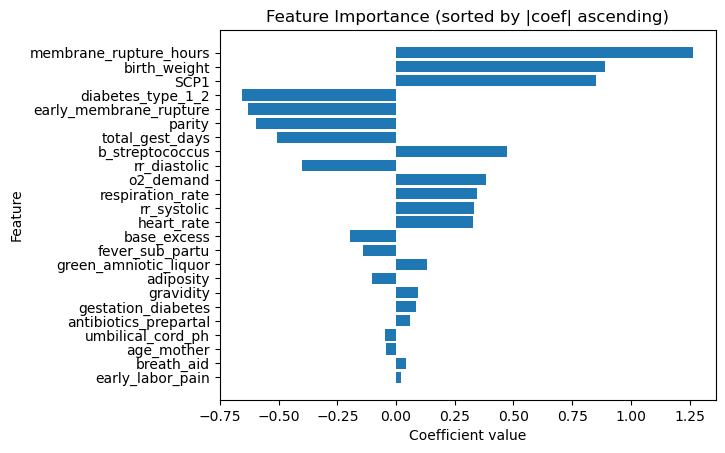

In [30]:
# features = np.array(FEATURES)
# sorted_idx = model_pipeline_LR.named_steps['classifier'].coef_[0].argsort()
# sorted_features = [FEATURES[i] for i in sorted_idx]
# plt.barh(sorted_features, model_pipeline_LR.named_steps['classifier'].coef_[0][sorted_idx])
coefs = model_pipeline_LR.named_steps['classifier'].coef_[0]
sorted_idx = np.argsort(np.abs(coefs))

sorted_features = [FEATURES[i] for i in sorted_idx]

plt.barh(sorted_features, coefs[sorted_idx])
plt.xlabel("Coefficient value")
plt.ylabel("Feature")
plt.title("Feature Importance (sorted by |coef| ascending)")
plt.show()

Confusion Matrix (Test Set):


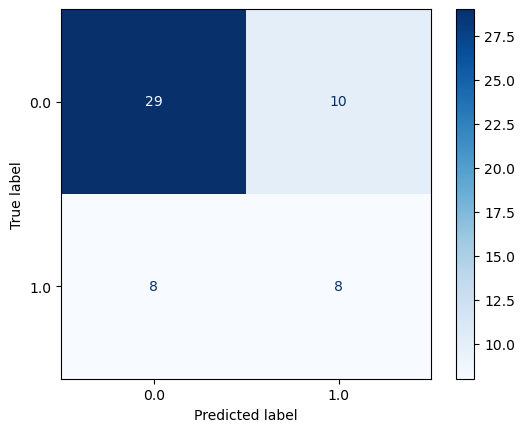

In [31]:
print("Confusion Matrix (Test Set):")
ConfusionMatrixDisplay.from_estimator(model_pipeline_LR, X_test, y_test, cmap='Blues')
plt.show()

In [82]:
# now for XGBoost
model_xgb = XGBClassifier(n_estimators=16, max_depth=4, learning_rate=0.4, objective='binary:logistic')
model_xgb.fit(X_train, y_train)

y_pred_test_xg = model_xgb.predict(X_test)
y_pred_proba_test_xg = model_xgb.predict_proba(X_test)[:, 1]

print("\nPerformance on the Test Set (Expanded Features):")
print(f"Test Set ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_test_xg):.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test_xg))


Performance on the Test Set (Expanded Features):
Test Set ROC AUC Score: 0.7147

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86        39
         1.0       0.70      0.44      0.54        16

    accuracy                           0.78        55
   macro avg       0.75      0.68      0.70        55
weighted avg       0.77      0.78      0.76        55



<BarContainer object of 24 artists>

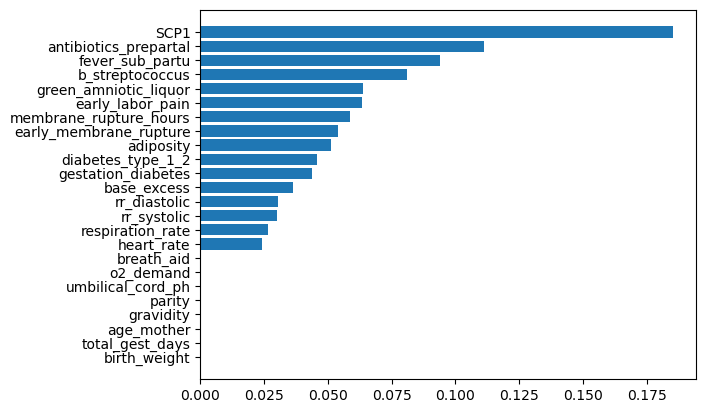

In [83]:
sorted_idx = model_xgb.feature_importances_.argsort()
plt.barh(FEATURES, model_xgb.feature_importances_[sorted_idx])

Confusion Matrix (Test Set) XGBoost:


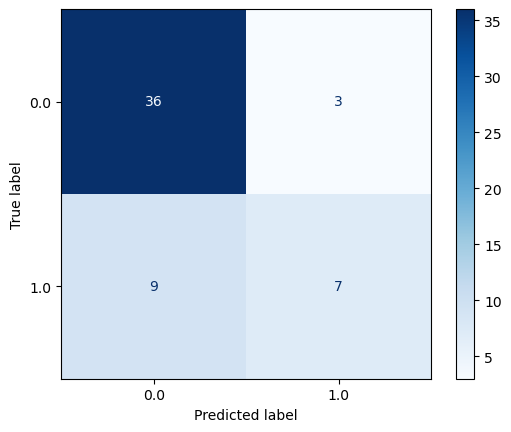

In [84]:
print("Confusion Matrix (Test Set) XGBoost:")
ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, y_test, cmap='Blues')
plt.show()